<a href="https://www.kaggle.com/code/deepakvk18/nasa-nearest-earth-objects?scriptVersionId=101956670" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Statement

There is an infinite number of objects in the outer space. Some of them are closer than we think. Even though we might think that a distance of 70,000 Km can not potentially harm us, but at an astronomical scale, this is a very small distance and can disrupt many natural phenomena. These objects/asteroids can thus prove to be harmful. Hence, it is wise to know what is surrounding us and what can harm us amongst those. Thus, this dataset compiles the list of NASA certified asteroids that are classified as the nearest earth object.

You can download the dataset from [here](https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects).

#NASA Nearest Earth Objects


The Objective of this model is to predict whether the particular asteroid is hazardous to Earth or not based on a certain parameters that are available in the dataset. This dataset compiles the list of NASA certified asteroids that are classified as the nearest earth object.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Importing the dataset with pandas

In [2]:
neo_df = pd.read_csv('/kaggle/input/nasa-nearest-earth-objects/neo.csv')
neo_df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [3]:
neo_df.orbiting_body.value_counts(), neo_df.sentry_object.value_counts()

(Earth    90836
 Name: orbiting_body, dtype: int64,
 False    90836
 Name: sentry_object, dtype: int64)

Since these columns do not have any information, they are not used in building the models.

In [4]:
input_cols = ['est_diameter_min','est_diameter_max','relative_velocity','miss_distance','absolute_magnitude']
target_cols = 'hazardous'

In [5]:
neo_df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [6]:
neo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


Since there are no NaN values, there is no need for preprocessing the data or cleaning the data. 

### Feature Explanation

Let us understand some terminologies of the data before trying to predict the hazardousness of the near earth object.

**est_min_diameter & est_max_diameter** is the minimum and maximum diameter of the space object. Since the space objects are not circular in shape, we cannot describe teir size with radius. That is why maximum and minimum size of the space objects are provided so that one can get the idea of how big the object is.

**relative_velocity** is the velocity of the object in relative to the motion of the earth.

**miss_distance** is the distance in kilometers the object has missed the earth

**absolute_magnitude** is the the magnitude (brightness) of a celestial object as it would be seen at a standard distance of 10 parsecs. In other words, it is the intrinsic luminosity of the object

# Exploratory Data Analysis

### Univariate Analysis

In [7]:
eda_df = neo_df.copy()

Let me Scale the features so that it would be easy for me to visualize the data.

In [8]:
scaler_eda = MinMaxScaler()
eda_df[input_cols] = scaler_eda.fit_transform(eda_df[input_cols])
eda_df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,90836.000000,90836.000000
mean,1.438288e+07,0.003347,0.003347,0.202138,0.495505,0.596458
std,2.087202e+07,0.007878,0.007878,0.106819,0.298856,0.120738
min,2.000433e+06,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.448110e+06,0.000492,0.000492,0.120005,0.230026,0.505215
50%,3.748362e+06,0.001260,0.001260,0.185765,0.505935,0.603671
75%,3.884023e+06,0.003768,0.003768,0.264881,0.755994,0.687109
max,5.427591e+07,1.000000,1.000000,1.000000,1.000000,1.000000


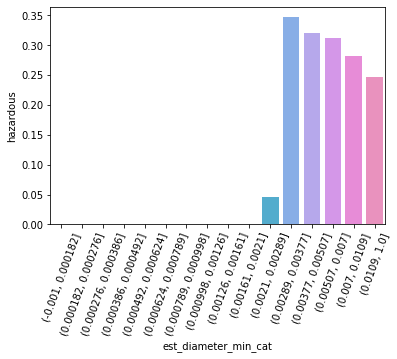

In [9]:
eda_df['est_diameter_min_cat']=pd.qcut(eda_df['est_diameter_min'],16)
bar = eda_df.groupby(by='est_diameter_min_cat').mean()
sns.barplot(data=bar, x=bar.index,y='hazardous')
plt.xticks(rotation=70);

The above Bar chart shows that objects with smaller diameter have lesser probability of being hazardous and as the size of the object increases, the probability of being hazardous increases to its peak before starting to decline. This might be due to the fact that it requires a strong amount of gravitational force to attract very large objects thereby the probability of large objects being hazardous decreases.

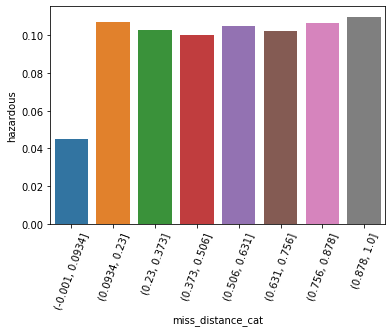

In [10]:
eda_df['miss_distance_cat']=pd.qcut(eda_df['miss_distance'],8)
bar = eda_df.groupby(by='miss_distance_cat').mean()
sns.barplot(data=bar, x=bar.index,y='hazardous')
plt.xticks(rotation=70);

As seen from the above histogram, miss distance is following a uniform distribution and do not give much information about whether the object is hazardous or not based on miss distance.

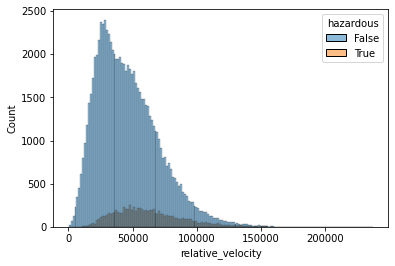

In [11]:
sns.histplot(data = neo_df, x= 'relative_velocity', hue = 'hazardous');

The above Histogram shows us that the relative velocity of space objects follow a normal distribution. As the relative velocity increases, the nuber of space objects also tend to increase and so does the number of hazardous objects before it starts to gradually decrease. To understand this more effeciently, we need a bar graph which gives us the probability of the object being hazardous.

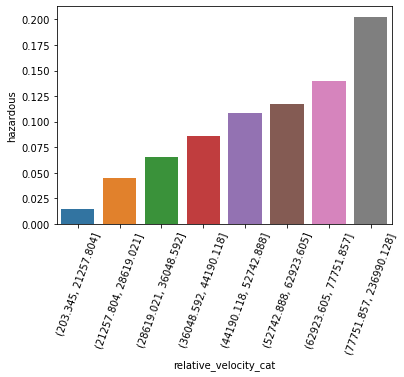

In [12]:
eda_df['relative_velocity_cat']=pd.qcut(neo_df['relative_velocity'],8)
bar = eda_df.groupby(by='relative_velocity_cat').mean()
sns.barplot(data=bar, x=bar.index,y='hazardous')
plt.xticks(rotation=70);

Eventhough in histogram it felt as if the probability started to decrease after its peak, the above graph depicts that the rate at which the number of objects decreases after the peak in that histogram is much greater than the rate at which the number of hazardous objects decreases, thereby increasing the probability of being hazardous. 

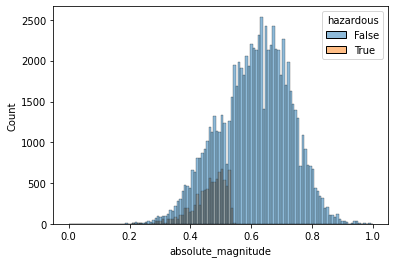

In [13]:
sns.histplot(data = eda_df, x= 'absolute_magnitude', hue = 'hazardous');

As seen from the above histogram, objects with absolute magnitude between 15 and 22 has more probability of being hazardous to earth when compared to other objects and absolute magnitude follows a normal distribution.

### Bivariate Analysis

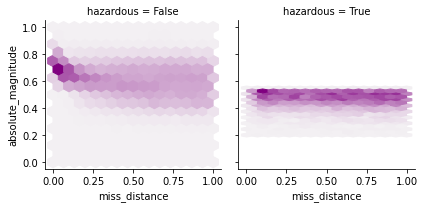

In [14]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)


g = sns.FacetGrid(eda_df,  col="hazardous")
g.map(hexbin,  "miss_distance","absolute_magnitude", color='purple');

As the graphs show above, there is a certain range of absolute magnitude between which the probability of hazardous objects are more. And the number of hazardous objects are more at that range irrespective of miss distance.

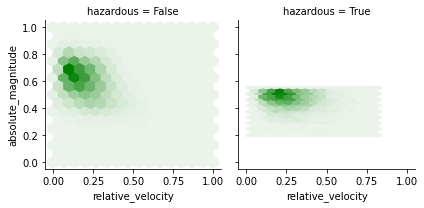

In [15]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)


g = sns.FacetGrid(eda_df,  col="hazardous")
g.map(hexbin, "relative_velocity","absolute_magnitude", color='green');

There is a certain region of the graph in which the number of hazardous objects are more when compared to the other region. (Relative Velocity between 0.1 and 0.5 and absolute magnitude between 0.4 and 0.6)

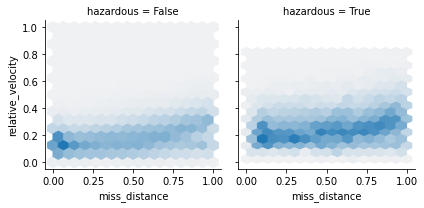

In [16]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)


g = sns.FacetGrid(eda_df,  col="hazardous")
g.map(hexbin, "miss_distance","relative_velocity");

The relationship between miss distance and relative velocity seems to be linear and we can even fit a regression line to find the relationship.

### Conclusions from Exploratory Data Analysis

1. Objects with smaller diameter have lesser probability of being hazardous and as the size of the object increases, the probability of being hazardous increases to its peak before starting to decline

2. As the relative velocity increases, the probability of the object being hazardous also increases.

3. Objects with absolute magnitude between 15 and 22 has more probability of being hazardous to earth when compared to other objects and absolute magnitude follows a normal distribution.

4. Objects with Normalized Relative Velocity between 0.1 and 0.5 and Normalized absolute magnitude between 0.4 and 0.6 have more probability of being hazardous.

5. As per the given data, miss distance alone is not that much useful to say that whether an object is hazardous or not.

# Data-Preprocessing

It will be good to normalize the values since I am going to use KNeighbors classifier and Support Vector Machine.}

In [17]:
scaler = MinMaxScaler()
input_cols = ['est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance',
       'absolute_magnitude']
target_col = 'hazardous'
def preprocess(dataframe):
    dataframe[input_cols] = scaler.fit_transform(dataframe[input_cols])
    return dataframe

neo_df = preprocess(neo_df)
neo_df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),0.031607,0.031607,0.056447,0.733141,Earth,False,0.312891,False
1,2277475,277475 (2005 WK4),0.006999,0.006999,0.309922,0.821364,Earth,False,0.449312,True
2,2512244,512244 (2015 YE18),0.019039,0.019039,0.481680,0.665740,Earth,False,0.358782,False
3,3596030,(2012 BV13),0.002531,0.002531,0.103726,0.339986,Earth,False,0.541093,False
4,3667127,(2014 GE35),0.006714,0.006714,0.179632,0.618634,Earth,False,0.453066,True


# Splitting the dataset

In [18]:
train_x, test_x, train_y, test_y = train_test_split(neo_df[input_cols], neo_df[target_col], test_size = 0.25)

# Building the models

Since this is a classfication problem, we can use Logistic Regression, K-Nearest Neighbours, Decision Tree Classifier, Random Forest Classifier, Gradient Boosting Classifier. 

### 1. Building the K Neighbors Classifier

In [19]:
knc = KNeighborsClassifier(n_neighbors=5,weights='distance')
knc.fit(train_x,train_y)
print(classification_report(train_y,knc.predict(train_x)))
print('---------------------------------------------------------')
print(classification_report(test_y,knc.predict(test_x)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     61467
        True       1.00      1.00      1.00      6660

    accuracy                           1.00     68127
   macro avg       1.00      1.00      1.00     68127
weighted avg       1.00      1.00      1.00     68127

---------------------------------------------------------
              precision    recall  f1-score   support

       False       0.93      0.96      0.95     20529
        True       0.47      0.33      0.39      2180

    accuracy                           0.90     22709
   macro avg       0.70      0.65      0.67     22709
weighted avg       0.89      0.90      0.89     22709



In [20]:
roc_auc_score(test_y,knc.predict_proba(test_x)[:,1])

0.8417136465264399

In [21]:
random_knc = RandomizedSearchCV(
                            estimator=KNeighborsClassifier(weights='distance'),
                            param_distributions={'n_neighbors':np.arange(1,20)},
                            n_jobs=-1,
                            random_state=43,
                            scoring='f1_macro')
random_knc.fit(train_x,train_y)
random_knc.best_params_

{'n_neighbors': 6}

In [22]:
print(classification_report(train_y,random_knc.predict(train_x)))
print('---------------------------------------------------------')
print(classification_report(test_y,random_knc.predict(test_x)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     61467
        True       1.00      1.00      1.00      6660

    accuracy                           1.00     68127
   macro avg       1.00      1.00      1.00     68127
weighted avg       1.00      1.00      1.00     68127

---------------------------------------------------------
              precision    recall  f1-score   support

       False       0.93      0.96      0.95     20529
        True       0.48      0.32      0.38      2180

    accuracy                           0.90     22709
   macro avg       0.70      0.64      0.67     22709
weighted avg       0.89      0.90      0.89     22709



In [23]:
roc_auc_score(test_y,random_knc.predict_proba(test_x)[:,1])

0.8608273661649373

Eventhough the f1 score has been depleted, it's interesting that roc_auc score has been improved. 

### 2. Building a XGBoost Classifier Model

In [24]:
xgb = XGBClassifier(random_state = 42)
xgb.fit(train_x,train_y)
print(classification_report(train_y,xgb.predict(train_x)))
print('---------------------------------------------------------')
print(classification_report(test_y,xgb.predict(test_x)))

              precision    recall  f1-score   support

       False       0.94      0.99      0.96     61467
        True       0.88      0.37      0.52      6660

    accuracy                           0.93     68127
   macro avg       0.91      0.68      0.74     68127
weighted avg       0.93      0.93      0.92     68127

---------------------------------------------------------
              precision    recall  f1-score   support

       False       0.93      0.99      0.96     20529
        True       0.69      0.28      0.39      2180

    accuracy                           0.92     22709
   macro avg       0.81      0.63      0.68     22709
weighted avg       0.90      0.92      0.90     22709



### Tuning the HyperParameters

Eventhough I got 92% accuracy in the XGBoost model, the precision and recall scores are not that much great as I am able to predict true values well when compared to the false values and so, my model is not able to predict the true hazardous objects well which is the objective of this model. The same is the case with my second model. This can be overcome by tuning the hyperparameters of the model.

In [25]:
def test_params_xgb(**params):
    model = XGBClassifier(random_state=42, n_jobs=-1, **params).fit(train_x, train_y)
    train_acuracy = accuracy_score(train_y,model.predict(train_x))
    test_accuracy = accuracy_score(test_y,model.predict(test_x))
    return train_acuracy, test_accuracy

In [26]:
def test_param_and_plot_xgb(param_name, param_values):
    train_accuracies, test_accuracies = [], []
    for value in param_values:
        params = {param_name: value}
        train_acuracy, test_accuracy = test_params_xgb(**params)
        train_accuracies.append(train_acuracy)
        test_accuracies.append(test_accuracy)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_accuracies, 'b-o')
    plt.plot(param_values, test_accuracies, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])

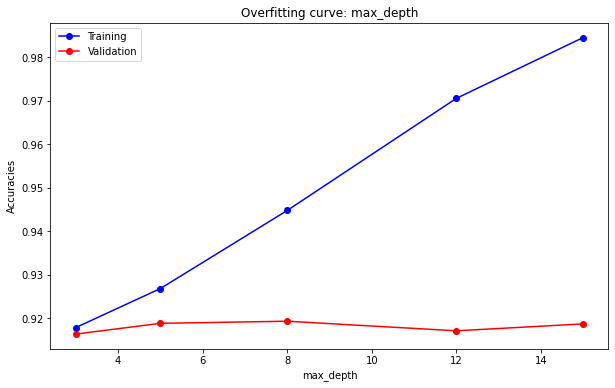

In [27]:
test_param_and_plot_xgb('max_depth',[3,5,8,12,15])

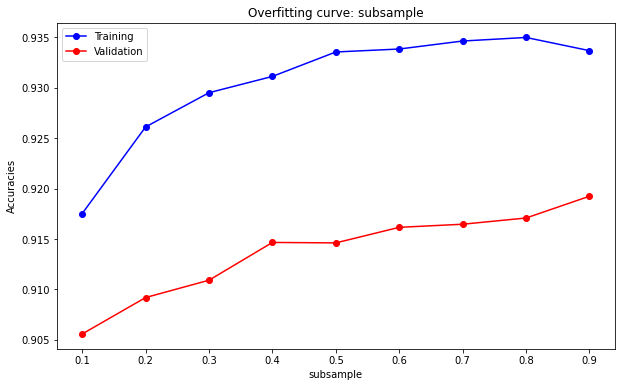

In [28]:
test_param_and_plot_xgb('subsample',np.arange(0.1,1,0.1))

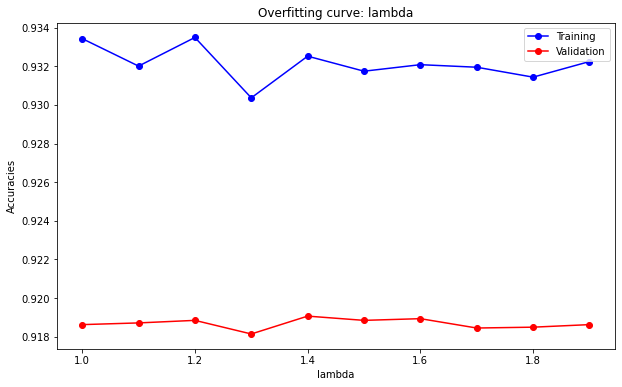

In [29]:
test_param_and_plot_xgb('lambda',np.arange(1,2,0.1))

### 3. Building AdaBoost Model

In [30]:
ada = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_jobs=-1,max_depth=5))
ada.fit(train_x,train_y)
print(classification_report(train_y,ada.predict(train_x)))
print('---------------------------------------------------------')
print(classification_report(test_y,ada.predict(test_x)))

              precision    recall  f1-score   support

       False       0.94      0.99      0.97     61467
        True       0.89      0.39      0.54      6660

    accuracy                           0.94     68127
   macro avg       0.91      0.69      0.75     68127
weighted avg       0.93      0.94      0.92     68127

---------------------------------------------------------
              precision    recall  f1-score   support

       False       0.93      0.99      0.96     20529
        True       0.74      0.29      0.42      2180

    accuracy                           0.92     22709
   macro avg       0.83      0.64      0.69     22709
weighted avg       0.91      0.92      0.91     22709



In [31]:
roc_auc_score(test_y, ada.predict_proba(test_x)[:,1])

0.9356007902895032

This is the Best ROC AUC score that I have gotten so far for this data. 

### Ensemble - Stacking

In [32]:
sk = StackingClassifier(estimators=[
                                    ('xgb',xgb),('knc',knc),('ada',ada)],
                       final_estimator=LogisticRegression(), n_jobs=-1)
sk.fit(train_x,train_y)
print(classification_report(train_y,sk.predict(train_x)))
print('---------------------------------------------------------')
print(classification_report(test_y,sk.predict(test_x)))

              precision    recall  f1-score   support

       False       0.95      1.00      0.97     61467
        True       0.95      0.53      0.68      6660

    accuracy                           0.95     68127
   macro avg       0.95      0.76      0.83     68127
weighted avg       0.95      0.95      0.94     68127

---------------------------------------------------------
              precision    recall  f1-score   support

       False       0.93      0.99      0.96     20529
        True       0.69      0.29      0.41      2180

    accuracy                           0.92     22709
   macro avg       0.81      0.64      0.68     22709
weighted avg       0.91      0.92      0.90     22709



In [33]:
roc_auc_score(test_y, sk.predict_proba(test_x)[:,1])

0.9309939709366164

In this case, stacking did not yield good results as AdaBoost itself predicted at a better score.

### ROC AUC Curves on Test Data

In [34]:
knc_x,knc_y,_ = roc_curve(test_y,random_knc.predict_proba(test_x)[:,1])
xgb_x,xgb_y,_ = roc_curve(test_y,xgb.predict_proba(test_x)[:,1])
sk_x,sk_y,_ = roc_curve(test_y,sk.predict_proba(test_x)[:,1])
ada_x,ada_y,_ = roc_curve(test_y,ada.predict_proba(test_x)[:,1])

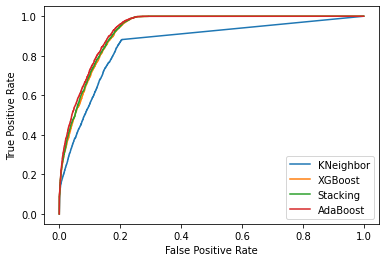

In [35]:
plt.plot(knc_x,knc_y,label='KNeighbor')
plt.plot(xgb_x,xgb_y,label='XGBoost')
plt.plot(sk_x,sk_y,label='Stacking')
plt.plot(ada_x,ada_y,label='AdaBoost')
plt.legend();
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

The ROC AUC curve shows that KNeighbor curve is not smooth and the other models are better. There is only a minute difference between XGBoost, AdaBoost and Stacking models.

# References

1. [How to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

2. [AdaBoostClassifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

3. [XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/parameter.html)

4. [StackingClassifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

5. [Metrics To Evaluate Machine Learning Algorithms in Python](https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/)

# Future Works

1. I would like to implement deep learning algorithms to maximize the macro f1 score.

2. I would also try to implement dimensionality reduction techniques to decrease the complexity of the model.

3. I would also try to improve these models by furthermore tuning hyperparameters and try differen methods like oversampling and undersampling to genaralize the model to improve its performaance.